# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [53]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

<>:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipython-input-3372919847.py:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if option is 'iris':
/tmp/ipython-input-3372919847.py:10: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif option is 'moon':
/tmp/ipython-input-3372919847.py:12: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif option is 'circles':
/tmp/ipython-input-3372919847.py:14: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif option i

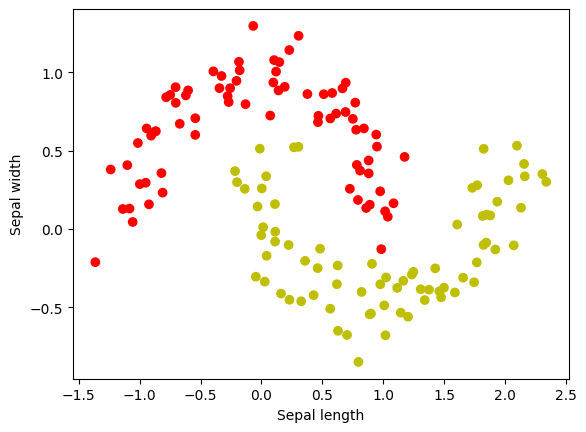

In [54]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option is 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option is 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option is 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option is 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [55]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [56]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 8),
            nn.Sigmoid(),
            #nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [57]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [58]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [59]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0209)


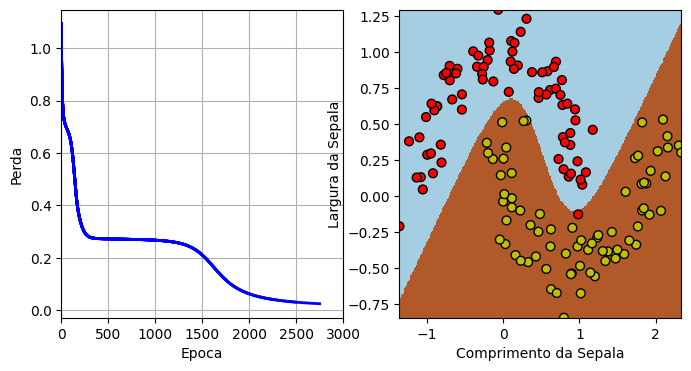

In [60]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [61]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([8, 2])
tensor([[-0.9378,  0.9054],
        [-0.6889,  0.0802],
        [ 0.4266,  0.3508],
        [-5.1749,  0.0929],
        [-0.8717,  0.8023],
        [ 0.8170, -0.6925],
        [-0.8190,  0.8932],
        [ 0.9944, -0.9717]])
dense.0.bias    torch.Size([8])
tensor([-0.3789,  0.3495, -0.1161,  2.6423,  0.0782, -0.0956, -0.1586, -0.5997])
dense.2.weight  torch.Size([8, 8])
tensor([[ 0.1838,  0.0482, -0.2800, -0.3247, -0.3415, -0.3439, -0.0172,  0.1929],
        [ 1.5357,  1.0332,  0.3978, -2.3321,  1.4726, -0.2371,  1.5094, -1.1145],
        [-0.2012, -0.2615, -0.3513, -0.2170,  0.1328, -0.2069, -0.2215, -0.1119],
        [-0.1093, -0.2638, -0.1485, -0.3498,  0.3111, -0.3422,  0.2257,  0.1327],
        [ 0.0536, -0.1635,  0.0991, -0.0481,  0.2278, -0.3019,  0.0192,  0.0315],
        [-1.4161, -0.5176,  0.1911,  3.0385, -1.3967,  1.2503, -0.7812,  1.9417],
        [-0.4460,  0.1887,  0.5077,  1.4912, -0.0497,  0.7004, -0.4595,  0.8452],
        [-0.0217, 

### Avaliação do classificador

In [62]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.9933333333333333


### Matriz de confusão

In [63]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,74,0
1,1,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.

-> Eu realizei uma mudança de aumentar os neurônios 64,64 e notei o modelço mais expressivo
-> a perda tente a descer mais rápido o bounday plot mostra regiões mais lisamente separada

-> Quando eu reduzi para 8,8 a rede fica muitoo básica, oo dataset moons e circles, a fronteirta
-> decisão fica quase linear.


2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.

-> O treinamento foi lento, os valoream saturam em 0 ou 1 com gradiente =0
-> A fronteira de decisão ficou menos expressiva, Sigmooid é basicamente um S mais leve
-> prejudicando a separação em datasets com curvas complexas
-> A Acurária final tende a ser não tão adequada


3. O que ocorre quando não se utiliza ativação não linear entre camadas?

-> O modelo irá perde toda sua capacidade de aprender relações não lineares,
-> as fronteiras de decisão irão ficar bem dizer retas
-> os datasets Moons e Circles irão ficar impossíveis de separar

## Principais aprendizados

-> O tamanho do mini-bacth relacionado a convergência realizada , notamos que nos mini-batchs menores a perda é maior, mas os aprendizados são mais rápidos por atualização, bem como nos mini-batches grandes as curvas são mais suaves, porém o seu processamento é mais lento , existe um aspecto que nem sempre maior é melhor.